### Transfer Learning
### Fine-tuning VGG16 on Cats & Dogs dataset
In this tutorial we will learn how to fine-tune a pre-trained network on a new dataset.
We will perform the following steps:
1. Load and normalizing the cats & dogs dataset
2. Load pre-trained VGG-16 
3. Remove top layers (fully connected layers)
4. Freeze the network
4. Add new layers (classifier)
5. Train the network
6. Test on test data

In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Uploading data to colab server

In [4]:
from google.colab import drive
drive.mount("./gdrive")
!unzip './gdrive/My Drive/colab/Assignment 5 Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [3]:
os.getcwd()


'/content'

In [4]:
os.getcwd()

'/content'

In [0]:
data_dir = "/content/Assignment 5 Dataset"

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(size=224, scale=(0.8,0.9)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=100, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


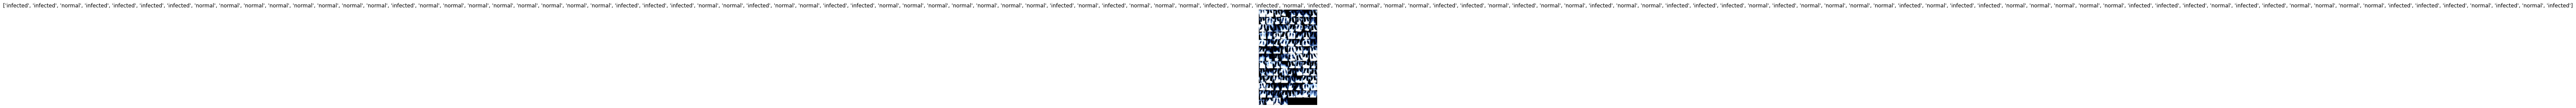

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Freezing all the layers except FC layer

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

### Adding New Layers

In [0]:
# Removing all the FC layer and assigning the 2 custom layers
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last  6 layer
print(features)

InFeature = vgg16.classifier[0].in_features
rollNo = 16
OutFeature =(rollNo * 10)+100
features.extend([nn.Linear(InFeature, OutFeature),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(OutFeature, len(class_names))])


[]


In [0]:
print(list(features))

[Linear(in_features=25088, out_features=260, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=260, out_features=2, bias=True)]


In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss fucntion and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.205465: : 120it [05:57,  2.98s/it]


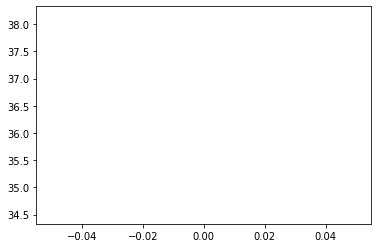

Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.217134: : 120it [05:33,  2.78s/it]


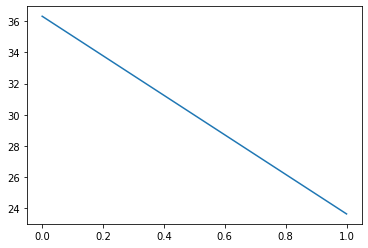

Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.263617: : 120it [05:31,  2.76s/it]


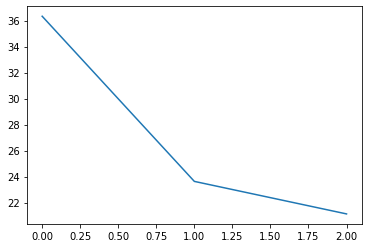

Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.093364: : 120it [05:32,  2.77s/it]


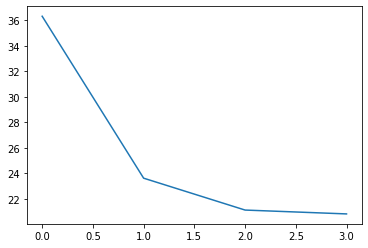

Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.097527: : 120it [05:31,  2.76s/it]


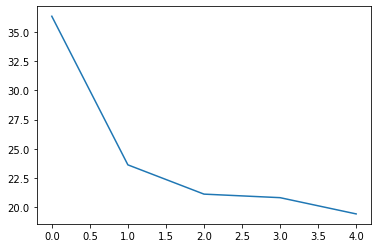

Train Epoch: 5 [11900/12000 (99%)]	Loss: 0.246758: : 120it [05:30,  2.76s/it]


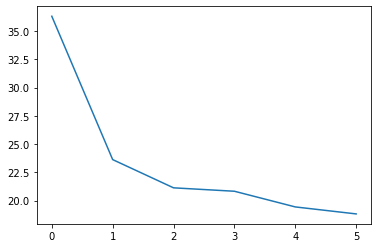

Train Epoch: 6 [11900/12000 (99%)]	Loss: 0.152554: : 120it [05:30,  2.75s/it]


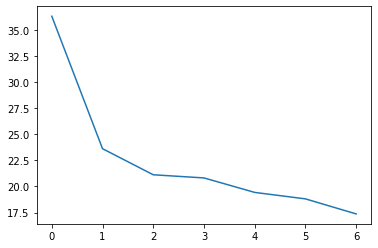

Train Epoch: 7 [11900/12000 (99%)]	Loss: 0.119289: : 120it [05:30,  2.75s/it]


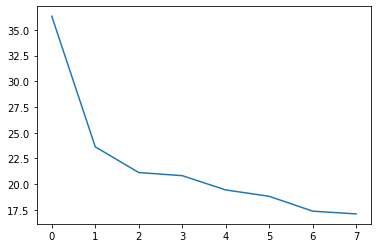

Train Epoch: 8 [11900/12000 (99%)]	Loss: 0.221107: : 120it [05:29,  2.75s/it]


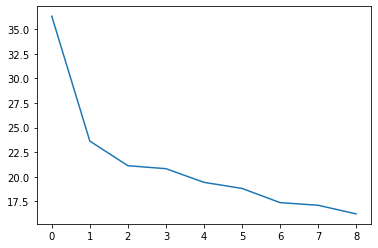

Train Epoch: 9 [11900/12000 (99%)]	Loss: 0.154513: : 120it [05:29,  2.75s/it]


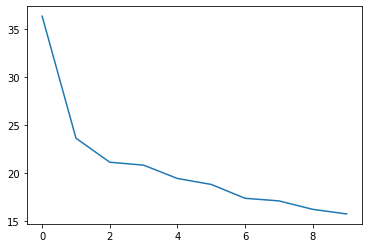

Finished Training


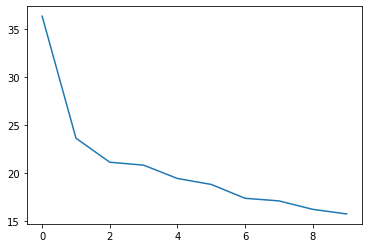

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
loss_curve=[]
vgg16.train()
train_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show()
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth’')

print('Finished Training')
plt.plot(train_loss)
plt.show()

In [0]:
#Validation Testing
correct_validation = 0
total_validation = 0
truth = []
predicted_=[]
loss_curve=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total_validation += labels.size(0)
        correct_validation += (predicted == labels).sum().item()

print('Accuracy of the network on the validation  images: %d %%' % (
    100 * correct_validation / total_validation))


Accuracy of the network on the validation  images: 92 %


[[565  50]
 [ 68 817]]


<Figure size 432x288 with 0 Axes>

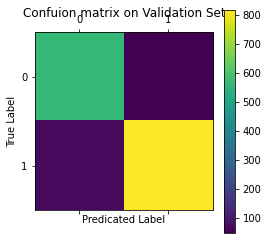

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Validation Set")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


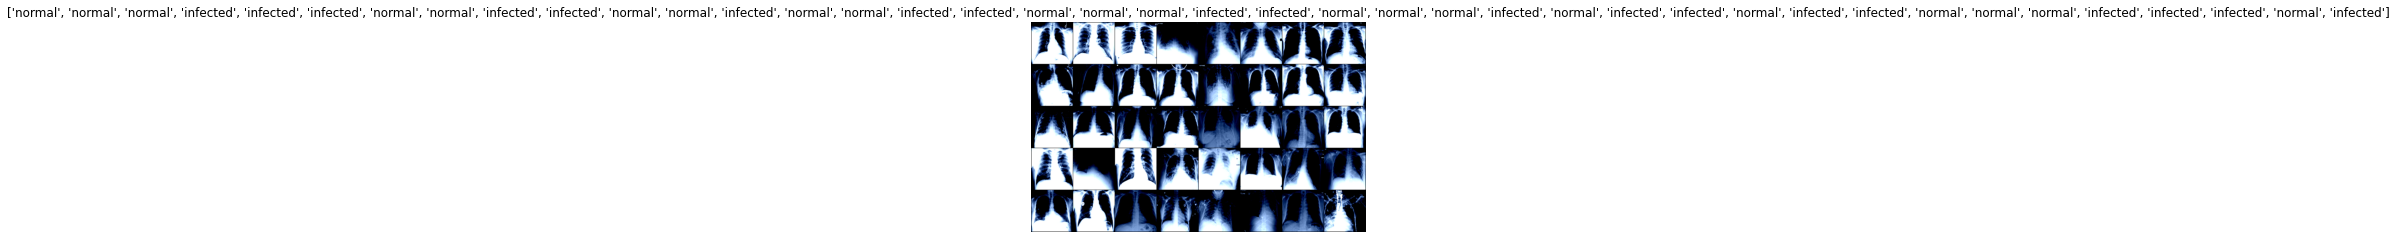

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected infected infected normal normal infected infected normal normal infected normal normal normal infected normal normal normal infected infected normal normal normal infected normal infected infected normal infected infected normal normal normal infected infected infected normal infected
Ground Truth:  normal normal normal infected infected infected normal normal infected infected normal normal infected normal normal infected infected normal normal normal infected infected normal normal normal infected normal infected infected normal infected infected normal normal normal infected infected infected normal infected


In [0]:
correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 97 %


[[593  22]
 [ 14 871]]


<Figure size 432x288 with 0 Axes>

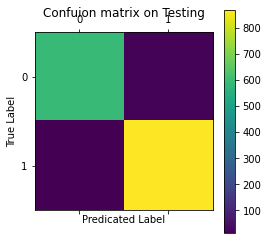

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [0]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9769357495881383
0.40505464480874315


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [0]:
print("F1-measure = ",temp)

F1-measure =  1.2151639344262295


#####RESNET Model

In [0]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)
print(res18)
print('Output Layer of res18 : ', res18)  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

In [0]:
print(res18.fc.in_features)

512


In [0]:
# Removing all the FC layer and assigning the 2 custom layers
InFeature = res18.fc.in_features
rollNo = 16
OutFeature =(rollNo * 10)+100



In [0]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(InFeature,OutFeature)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(OutFeature,len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

res18.fc = fc

In [0]:
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)


0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.686818: : 0it [00:01, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.686818: : 1it [00:01,  1.02s/it]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.708559: : 1it [00:02,  1.02s/it]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.708559: : 2it [00:02,  1.02s/it]
Train Epoch: 0 [80/12000 (1%)]	Loss: 0.681208: : 2it [00:03,  1.02s/it]
Train Epoch: 0 [80/12000 (1%)]	Loss: 0.681208: : 3it [00:03,  1.02s/it]
Train Epoch: 0 [120/12000 (1%)]	Loss: 0.753432: : 3it [00:04,  1.02s/it]
Train Epoch: 0 [120/12000 (1%)]	Loss: 0.753432: : 4it [00:04,  1.00s/it]
Train Epoch: 0 [160/12000 (1%)]	Loss: 0.685874: : 4it [00:05,  1.00s/it]
Train Epoch: 0 [160/12000 (1%)]	Loss: 0.685874: : 5it [00:05,  1.00it/s]
Train Epoch: 0 [200/12000 (2%)]	Loss: 0.654789: : 5it [00:06,  1.00it/s]
Train Epoch: 0 [200/12000 (2%)]	Loss: 0.654789: : 6it [00:06,  1.05s/it]
Train Epoch: 0 [240/12000 (2%)]	Loss: 0.643363: : 6it [00:07,  1.05s/it]
Train Epoch: 0 [240/12000 (2%)]	Loss: 0.643

Finished Training


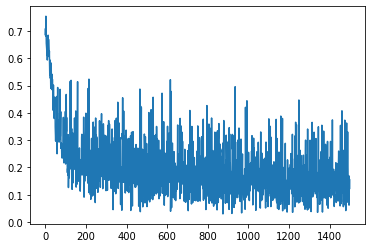

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
loss_curve=[]
res18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = res18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(res18.state_dict(), '‘res18_FC_Only.pth’')

print('Finished Training')
plt.plot(loss_curve)
plt.show()

In [0]:
#Validation Testing
correct_validation = 0
total_validation = 0
truth = []
predicted_=[]
loss_curve=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total_validation += labels.size(0)
        correct_validation += (predicted == labels).sum().item()

print('Accuracy of the network on the validation  images: %d %%' % (
    100 * correct_validation / total_validation))


Accuracy of the network on the validation  images: 90 %


[[528  87]
 [ 59 826]]


<Figure size 432x288 with 0 Axes>

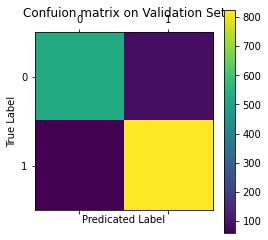

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Validation Set")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


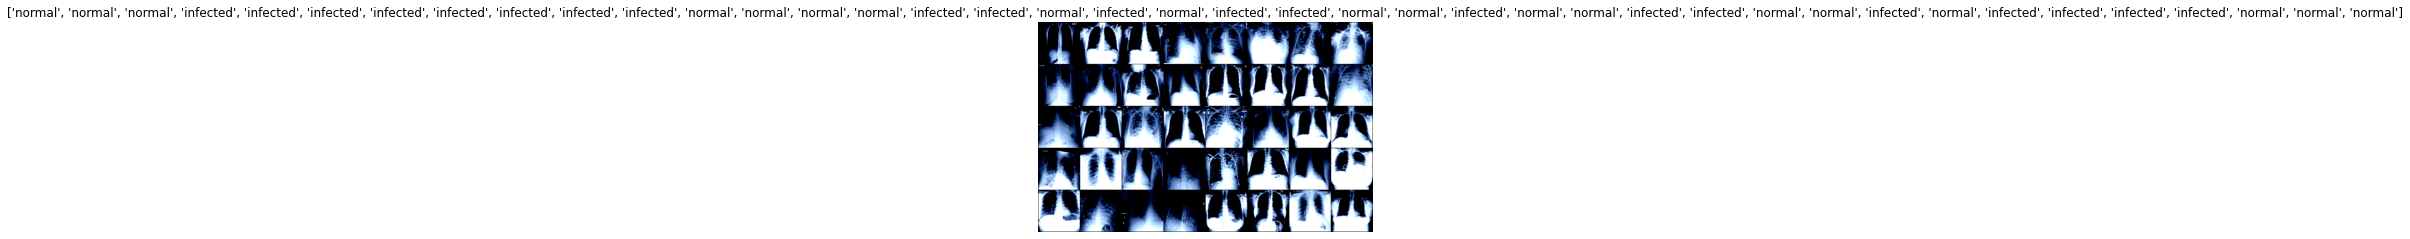

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 96 %


[[578  37]
 [ 11 874]]


<Figure size 432x288 with 0 Axes>

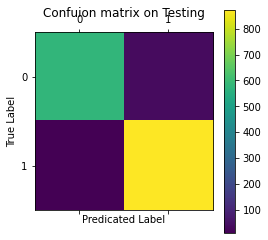

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [0]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9813242784380306
0.39807162534435264


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [0]:
print("F1-measure = ",temp)

F1-measure =  1.194214876033058


#Task2 Part 1

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##Freeze all layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

#when we have freeezed all layers then we dont need to do any training as it is not benficial beacuse the weights wont update so we simply find the accuray 
#already trained model

In [0]:
# Removing all the FC layer and assigning the 2 custom layers
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last  6 layer
print(features)

InFeature = vgg16.classifier[0].in_features
rollNo = 16
OutFeature =(rollNo * 10)+100
features.extend([nn.Linear(InFeature, OutFeature),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(OutFeature, len(class_names))])



[]


In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
loss_curve=[]
vgg16.train()
train_loss=[]

correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 43 %


[[551  64]
 [781 104]]


<Figure size 432x288 with 0 Axes>

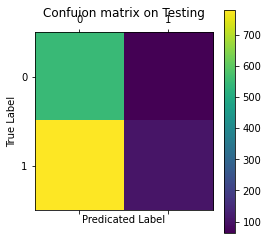

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [0]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.41366366366366364
0.8412213740458016


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [0]:
print("F1-measure = ",temp)

F1-measure =  2.5236641221374048


# Frezze First 10 layer of VGG


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
# Freeze training for all layers
layer_counter=1
for param in vgg16.features:
    if(layer_counter>10):
      break
    param.require_grad = False
    layer_counter=layer_counter+1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.080470: : 120it [05:48,  2.90s/it]


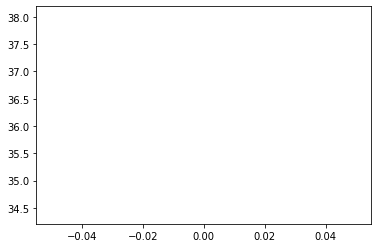

Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.120676: : 120it [05:38,  2.82s/it]


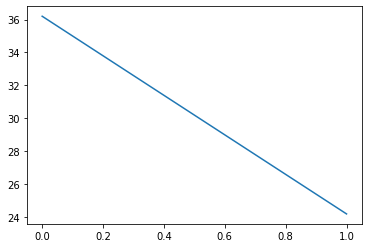

Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.173648: : 120it [05:37,  2.81s/it]


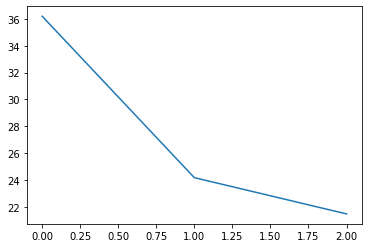

Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.175143: : 120it [05:36,  2.81s/it]


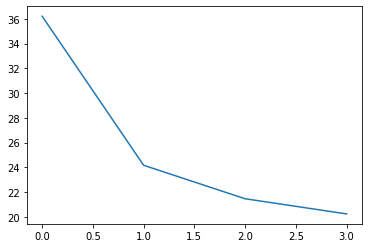

Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.133614: : 120it [05:35,  2.80s/it]


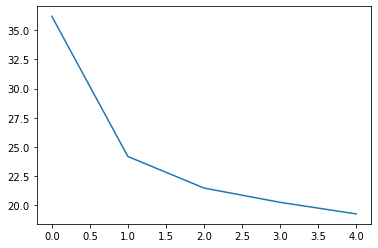

Finished Training


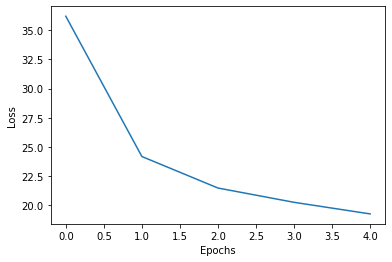

In [0]:
## Training 
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
loss_curve=[]
vgg16.train()
train_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show()
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth’')

print('Finished Training')
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [0]:
correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 96 %


[[593  22]
 [ 26 859]]


<Figure size 432x288 with 0 Axes>

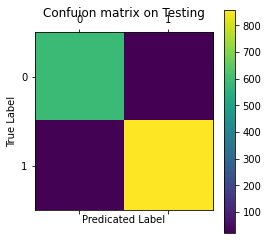

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [0]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9579967689822294
0.4084022038567493


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [0]:
print("F1-measure = ",temp)

F1-measure =  1.2252066115702478


#Freezing only one Convoltional layer


In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# Freeze training for all layers
layer_counter=0
for param in vgg16.features:
    if(layer_counter>27):
      break
    param.require_grad = False
    layer_counter=layer_counter+1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.205043: : 120it [06:39,  3.33s/it]


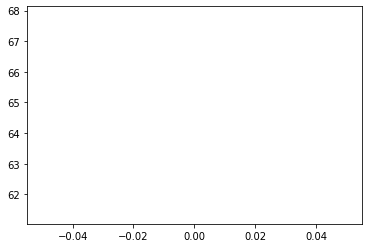

Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.120222: : 120it [06:28,  3.23s/it]


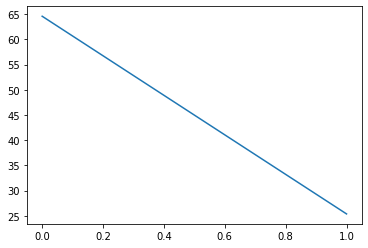

Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.247924: : 120it [06:17,  3.15s/it]


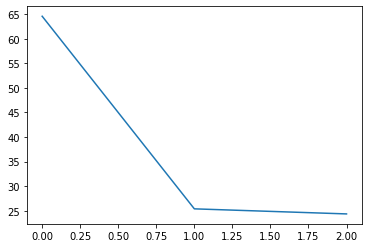

Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.287543: : 120it [06:19,  3.16s/it]


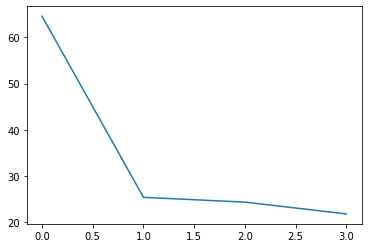

Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.160595: : 120it [06:19,  3.16s/it]


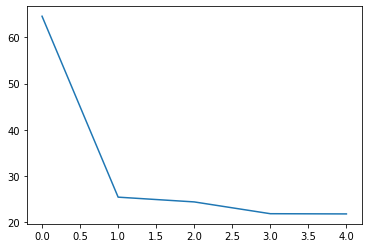

Finished Training


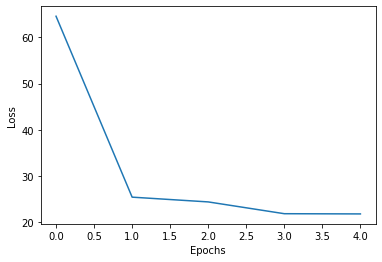

In [10]:
## Training 
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
loss_curve=[]
vgg16.train()
train_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show()
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth’')

print('Finished Training')
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 96 %


[[576  39]
 [ 11 874]]


<Figure size 432x288 with 0 Axes>

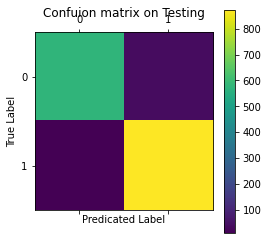

In [12]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [13]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9812606473594548
0.3972413793103448


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [15]:
print("F1-measure = ",temp)

F1-measure =  1.1917241379310344


#Unfreeze All FC layers only rest of the network is Freezed

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all layers
layer_counter=0
for param in vgg16.features:
    if(layer_counter>30):
      break
    param.require_grad = False
    layer_counter=layer_counter+1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.266232: : 120it [05:41,  2.84s/it]


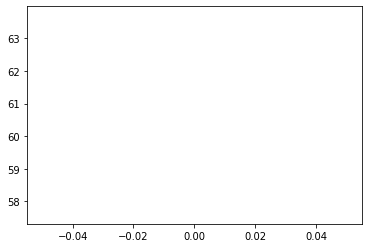

Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.178547: : 120it [05:40,  2.83s/it]


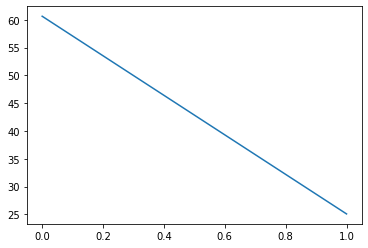

Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.278057: : 120it [05:38,  2.82s/it]


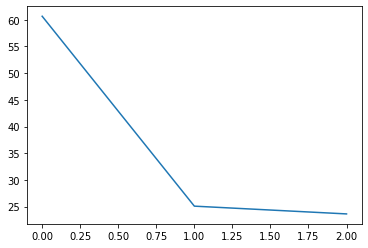

Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.136376: : 120it [05:37,  2.82s/it]


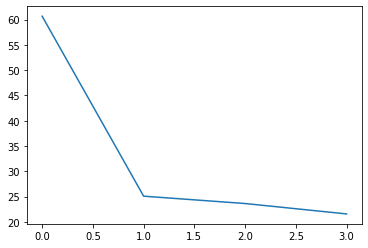

Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.209573: : 120it [05:37,  2.82s/it]


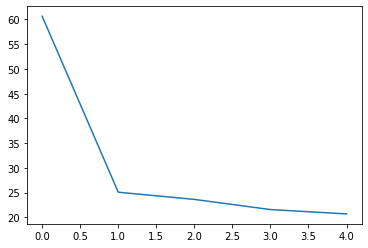

Finished Training


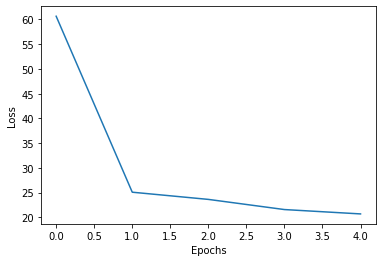

In [0]:
## Training 
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
loss_curve=[]
vgg16.train()
train_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show()
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth’')

print('Finished Training')
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [0]:
correct = 0
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 96 %


[[574  41]
 [  8 877]]


<Figure size 432x288 with 0 Axes>

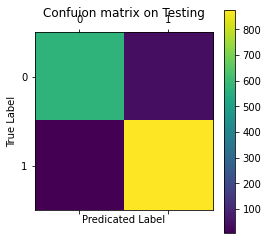

In [0]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [0]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9862542955326461
0.3955892487939352


In [0]:
temp=2*Precison*Recall/Precison+Recall

In [0]:
print("F1-measure = ",temp)

F1-measure =  1.1867677463818056


#TASK2 part 2 RESNET18



In [44]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)
print(res18)
print('Output Layer of res18 : ', res18)  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

In [0]:
# Removing all the FC layer and assigning the 2 custom layers
InFeature = res18.fc.in_features
rollNo = 16
OutFeature =(rollNo * 10)+100
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(InFeature,OutFeature)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(OutFeature,len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

res18.fc = fc



In [47]:
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

In [49]:
correct = 0

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 59 %


[[  9 606]
 [  1 884]]


<Figure size 432x288 with 0 Axes>

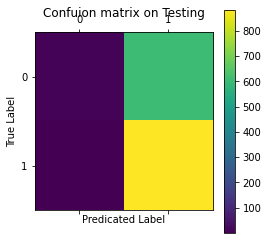

In [50]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

##Now freezing all layer except the FC layer


In [0]:
# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

In [16]:
for param in res18.fc:
  print(param)

Linear(in_features=512, out_features=260, bias=True)
ReLU()
Linear(in_features=260, out_features=2, bias=True)
LogSoftmax()


In [0]:
for param in res18.fc:
  param.require_grad = True

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.217373: : 120it [05:19,  2.66s/it]
Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.228205: : 120it [04:52,  2.44s/it]
Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.159497: : 120it [04:52,  2.43s/it]
Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.212685: : 120it [04:50,  2.42s/it]
Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.176735: : 120it [04:58,  2.49s/it]


Finished Training


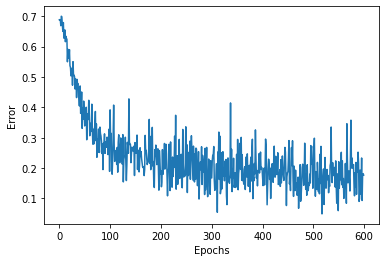

In [18]:
## now Training 

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
loss_curve=[]
res18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = res18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(res18.state_dict(), '‘res18_FC_Only.pth’')

print('Finished Training')
plt.plot(loss_curve)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()   

In [19]:
correct = 0

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 95 %


[[565  50]
 [ 12 873]]


<Figure size 432x288 with 0 Axes>

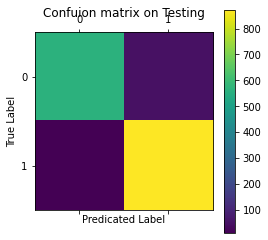

In [21]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [22]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9792027729636048
0.39290681502086233


In [29]:
temp=(2*Precison*Recall)/Precison+Recall
print("F1-Measure = ",temp)

F1-Measure =  1.178720445062587


In [0]:
#now unfreezing only one convoltional layer
# first need to freeze all layers
for param in res18.fc:
  param.require_grad = False

for param in res18.parameters():
  param.require_grad = False

In [33]:
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# unfreeze only one Convolutional layer
res18.layer1.requires_grad = True

Train Epoch: 0 [11900/12000 (99%)]	Loss: 0.099220: : 120it [04:50,  2.42s/it]
Train Epoch: 1 [11900/12000 (99%)]	Loss: 0.174565: : 120it [04:52,  2.44s/it]
Train Epoch: 2 [11900/12000 (99%)]	Loss: 0.177395: : 120it [04:52,  2.44s/it]
Train Epoch: 3 [11900/12000 (99%)]	Loss: 0.102947: : 120it [04:52,  2.44s/it]
Train Epoch: 4 [11900/12000 (99%)]	Loss: 0.124782: : 120it [04:54,  2.45s/it]


Finished Training


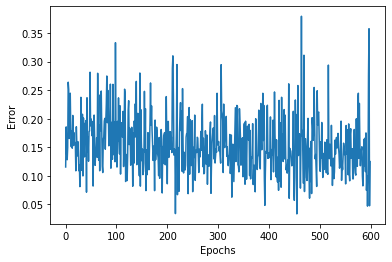

In [37]:
## now Training 

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
loss_curve=[]
res18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = res18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(res18.state_dict(), '‘res18_FC_Only.pth’')

print('Finished Training')
plt.plot(loss_curve)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()   

In [38]:
correct = 0

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res18.to(device)
total = 0
truth = []
predicted_ = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            predicted_.append(i.item())
        for i in labels:
            truth.append(i.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the  test images: 96 %


[[567  48]
 [  8 877]]


<Figure size 432x288 with 0 Axes>

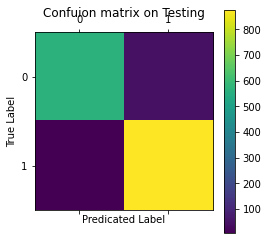

In [39]:
  matrix = confusion_matrix(truth, predicted_)
  print(matrix)
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title("Confuion matrix on Testing")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

In [40]:
TP = matrix[0][0]
FN = matrix[0][1]
FP = matrix[1][0]
FN = matrix[1][1]

Precison = TP/(TP+FP)
Recall   = TP/(TP+FN)
print(Precison)
print(Recall)

0.9860869565217392
0.3926592797783934


In [41]:
temp=(2*Precison*Recall)/Precison+Recall
print("F1-Measure = ",temp)

F1-Measure =  1.17797783933518
